## timediff2Rank

basedon: 11.OracleRank/laptime_rank_timediff_dataset-oracle.ipynb

rank prediction by timediff forecasting models

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
import os
os.getcwd()
GPUID = 1

### load time&score data

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
#events = ['Gateway']

#events = ['Indy500']
#events = ['Phoenix']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata

# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    #uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
    #                  "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
    #                  "last_pitted_lap","start_position","laps_led"], axis=1)
    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", 
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
        
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    #df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    #df = uni_ds[['car_number','completed_laps','rank',
    #             'rank_diff','time_diff',"current_status", "track_status", "lap_status",'elapsed_time']]
    
    df = uni_ds[['car_number','completed_laps','time_diff','rank','track_status', 'lap_status','elapsed_time']]
    
    return df

In [5]:
stagedata = {}
global_carids = {}
traindata = None
cur_carid = 0
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

    #build the carid map
    for car in carlist:
        if car not in global_carids:
            global_carids[car] = cur_carid
            cur_carid += 1

count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30}
#cars= 11
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98}
#cars= 23


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Phoenix: carno=23, lapnum=251
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33
Indy500: carno=33, lapnum=201
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {5, 9, 10, 15, 18, 22, 27, 28, 30}
#cars= 9
cars: {1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 47, 55, 57, 59, 60, 68, 73, 83, 88, 98}
#cars= 32
Texas: carno=32, lapnum=249
count of completed cars: 5
completed cars: [ 5 21 30  1  6]
cars: {1, 5, 6, 21, 30}
#cars= 5
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
#cars= 22
Iowa: carno=22, lapnum=301
count of completed cars: 4
completed cars: [27 12  9 18]
cars: {9, 18, 27, 12}
#cars= 4
cars: {1, 4, 5, 

In [6]:
event='Indy500'
alldata, rankdata, acldata = stagedata[event]

### load prediction data

In [4]:
# start from here
import pickle
with open('laptime_rank_timediff-oracle-%s.pickle'%year, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [5]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def make_dataset(runs, prediction_length, freq, 
                       useeid = False,
                       run_ts=COL_LAPTIME, 
                       train_ratio = 0.8,
                       use_global_dict = True,
                       oracle_mode = MODE_ORACLE,
                       test_cars = [],
                       half_moving_win = True 
                ):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    
    #select run
    if runs>=0:
        _laptime_data = [laptime_data[runs].copy()]
    else:
        _laptime_data = laptime_data.copy()
    
   
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in _laptime_data:
        _train = []
        _test = []
        
        #statistics on the ts length
        ts_len = [ _entry.shape[1] for _entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        
        print(f'====event:{events[_data[0]]}, train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)}')
                
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            if ( totallen < train_len + prediction_length):
                print(f'a short ts: carid={_data[1][rowid]}，len={totallen}')
                continue                
            
            if use_global_dict:
                carno = _data[1][rowid]
                carid = global_carids[_data[1][rowid]]
            else:
                #simulation dataset, todo, fix the carids as decoder
                carno = rowid
                carid = rowid

            #eval on carids
            if test_cars and (carno not in test_cars):
                continue                
            
            if useeid:
                static_cat = [carid, _data[0]]    
            else:
                static_cat = [carid]    
                
            # selection of features
            if test_flag(oracle_mode, MODE_NOTRACK):                
                rec[COL_TRACKSTATUS, :] = 0
            if test_flag(oracle_mode, MODE_NOLAP):                
                rec[COL_LAPSTATUS, :] = 0
                
            # split and add to dataset record
            _train.append({'target': rec[run_ts,:train_len].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': [rec[COL_TRACKSTATUS,:train_len],
                                   rec[COL_LAPSTATUS,:train_len]]
                          }
                          )
            
            # multiple test ts(rolling window as half of the prediction_length)
            test_rec_cnt = 0
            step = -int(prediction_length/2) if half_moving_win else -prediction_length
            for endpos in range(totallen, train_len+prediction_length, step):
                
                track_rec = rec[COL_TRACKSTATUS, :endpos].copy()
                lap_rec = rec[COL_LAPSTATUS, :endpos].copy()
                
                # test mode
                if test_flag(oracle_mode, MODE_TESTCURTRACK):
                    # since nan does not work, use cur-val instead
                    track_rec[-prediction_length:] = track_rec[-prediction_length - 1]
                    #track_rec[-prediction_length:] = random.randint(0,1)
                    #lap_rec[-prediction_length:] = lap_rec[-prediction_length - 1]
                    lap_rec[-prediction_length:] = 0
                elif test_flag(oracle_mode, MODE_TESTZERO):
                    #set prediction part as nan
                    #track_rec[-prediction_length:] = np.nan
                    #lap_rec[-prediction_length:] = np.nan
                    track_rec[-prediction_length:] = 0
                    lap_rec[-prediction_length:] = 0                    
                
                _test.append({'target': rec[run_ts,:endpos].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': [track_rec,lap_rec]
                            #'feat_dynamic_real': [rec[COL_TRACKSTATUS,:endpos],
                            #       rec[COL_LAPSTATUS,:endpos]] 
                             }
                          )   
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'prediction_length:{prediction_length},train len:{len(train_set)}, test len:{len(test_set)}')
    
    train_ds = ListDataset(train_set, freq=freq)
    test_ds = ListDataset(test_set, freq=freq)    
    
    return train_ds, test_ds, train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        

In [6]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1, marker='.')  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()
        


def long_predict(output):
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

    blockid = 0
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples

        blockid = (blockid + 1) % 2

    #first block
    newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

    #last block
    blockid = 1
    newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples

    target.samples = newsamples

    plot_prob_forecasts_ex([tss[0]],[target],output)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))    
    
    return target

### long prediction

In [14]:
cardinality = [len(global_carids)]
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

#model configure
ueseid = False
interpolate = False
ipstr = '' if interpolate else '-noip'
prediction_length = 10
freq = "1min"

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, 
                                     oracle_mode=MODE_TESTCURTRACK,
                                     run_ts = COL_TIMEDIFF,
                                     test_cars=test_cars)

====event:Indy500, train_len=160, max_len=200, min_len=200
a short ts: carid=3，len=146
a short ts: carid=10，len=57
carno:12, totallen:200, nancount:0, test_reccnt:6
a short ts: carid=13，len=67
a short ts: carid=18，len=137
a short ts: carid=24，len=154
a short ts: carid=30，len=46
a short ts: carid=32，len=110
a short ts: carid=33，len=46
train len:1, test len:6


INFO:root:Using GPU


tss len=6, forecasts len=6
165 190
sampel# x predictlen:  100 10


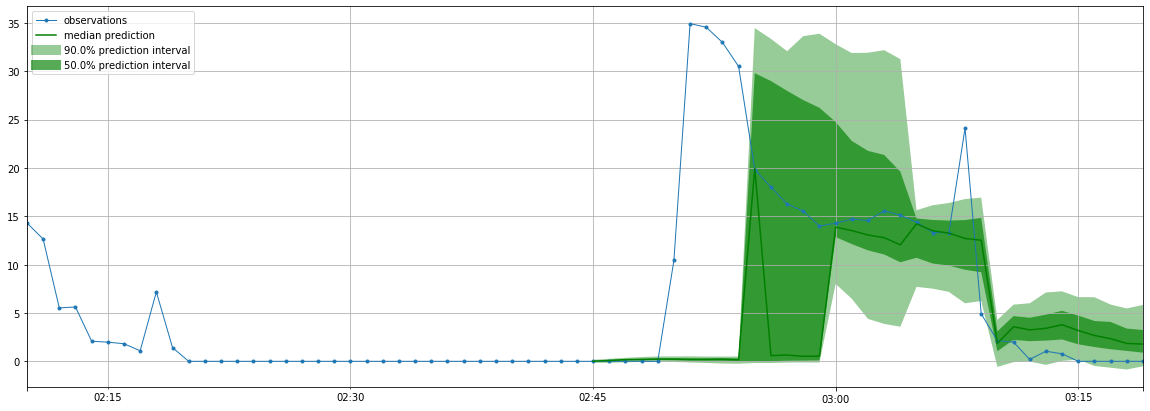

Running evaluation: 100%|██████████| 6/6 [00:00<00:00, 15.98it/s]

{
    "MSE": 211.3145212173462,
    "abs_error": 619.3373718261719,
    "abs_target_sum": 754.6316108703613,
    "abs_target_mean": 12.577193514506023,
    "seasonal_error": 1.3924166628559826,
    "MASE": 7.879813560014202,
    "sMAPE": 1.2124134606967993,
    "MSIS": 250.36884870127622,
    "QuantileLoss[0.1]": 244.9174921862781,
    "Coverage[0.1]": 0.3833333333333333,
    "QuantileLoss[0.5]": 619.3373879403807,
    "Coverage[0.5]": 0.5666666666666668,
    "QuantileLoss[0.9]": 766.9330940306187,
    "Coverage[0.9]": 0.6166666666666666,
    "RMSE": 14.536661281647385,
    "NRMSE": 1.1557953103672447,
    "ND": 0.8207148533200901,
    "wQuantileLoss[0.1]": 0.32455238908399325,
    "wQuantileLoss[0.5]": 0.8207148746738322,
    "wQuantileLoss[0.9]": 1.0163013091196502,
    "mean_wQuantileLoss": 0.7205228576258252,
    "MAE_Coverage": 0.21111111111111117
}


In [15]:
#load predictor
model='deepAR-Oracle-timediff-curtrack-indy-f1min-t10-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-Oracle-timediff-curtrack-t10')

INFO:root:Using GPU


tss len=6, forecasts len=6
165 190
sampel# x predictlen:  100 10


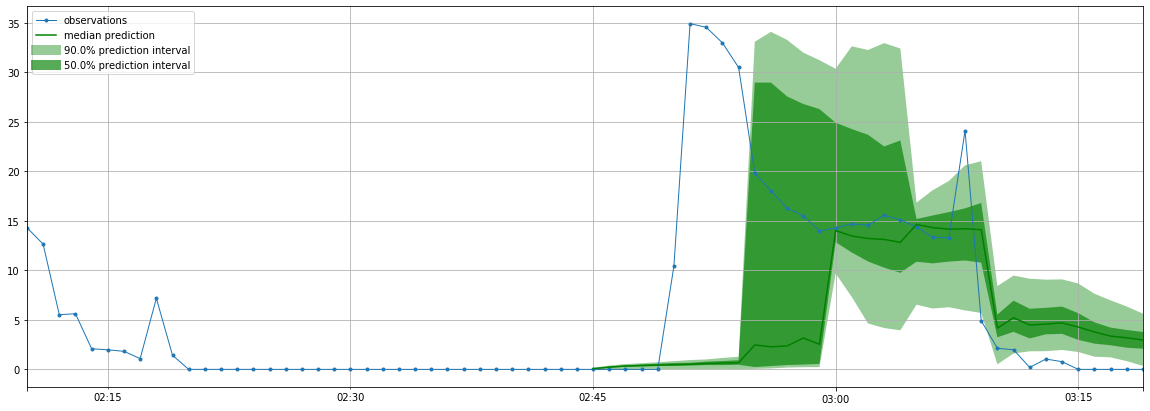

Running evaluation: 100%|██████████| 6/6 [00:00<00:00, 16.34it/s]

{
    "MSE": 211.5328582763672,
    "abs_error": 640.4404487609863,
    "abs_target_sum": 754.6316108703613,
    "abs_target_mean": 12.577193514506023,
    "seasonal_error": 1.3924166628559826,
    "MASE": 8.10752828328206,
    "sMAPE": 1.2247663577924897,
    "MSIS": 246.36942579634925,
    "QuantileLoss[0.1]": 258.61647613234817,
    "Coverage[0.1]": 0.45,
    "QuantileLoss[0.5]": 640.4404432997108,
    "Coverage[0.5]": 0.5833333333333334,
    "QuantileLoss[0.9]": 747.464780831337,
    "Coverage[0.9]": 0.6666666666666666,
    "RMSE": 14.544169219187708,
    "NRMSE": 1.1563922589258928,
    "ND": 0.848679593506994,
    "wQuantileLoss[0.1]": 0.34270559622339497,
    "wQuantileLoss[0.5]": 0.8486795862699853,
    "wQuantileLoss[0.9]": 0.9905028759254354,
    "mean_wQuantileLoss": 0.7272960194729386,
    "MAE_Coverage": 0.22222222222222224
}


In [16]:
#load predictor
model='deepAR-Oracle-timediff-all-indy-f1min-t10-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-Oracle-timediff-all-t10')

INFO:root:Using GPU


tss len=6, forecasts len=6
165 190
sampel# x predictlen:  100 10


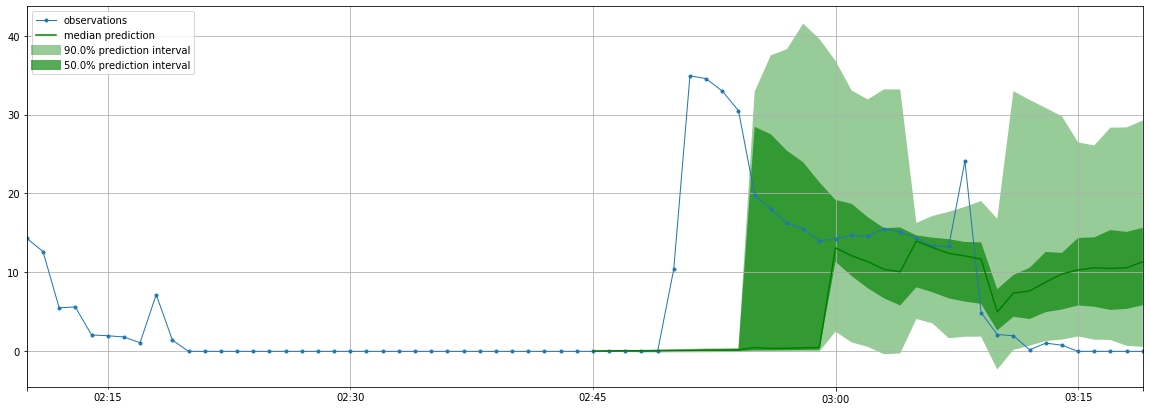

Running evaluation: 100%|██████████| 6/6 [00:00<00:00, 29.88it/s]

{
    "MSE": 224.33876190185546,
    "abs_error": 651.3909950256348,
    "abs_target_sum": 754.6316108703613,
    "abs_target_mean": 12.577193514506023,
    "seasonal_error": 1.3924166628559826,
    "MASE": 8.176464475765025,
    "sMAPE": 1.2397657121600194,
    "MSIS": 249.29321615238294,
    "QuantileLoss[0.1]": 253.3766143467277,
    "Coverage[0.1]": 0.2833333333333334,
    "QuantileLoss[0.5]": 651.3909947164357,
    "Coverage[0.5]": 0.5499999999999999,
    "QuantileLoss[0.9]": 797.8200382694602,
    "Coverage[0.9]": 0.6333333333333333,
    "RMSE": 14.977942512303066,
    "NRMSE": 1.1908811369585843,
    "ND": 0.8631907087411127,
    "wQuantileLoss[0.1]": 0.33576199392773043,
    "wQuantileLoss[0.5]": 0.8631907083313776,
    "wQuantileLoss[0.9]": 1.0572311400383654,
    "mean_wQuantileLoss": 0.7520612807658246,
    "MAE_Coverage": 0.16666666666666666
}


In [17]:
#load predictor
model='deepAR-timediff-all-indy-f1min-t10-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-timediff-all-t10')

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=6, forecasts len=6
165 190
sampel# x predictlen:  100 10


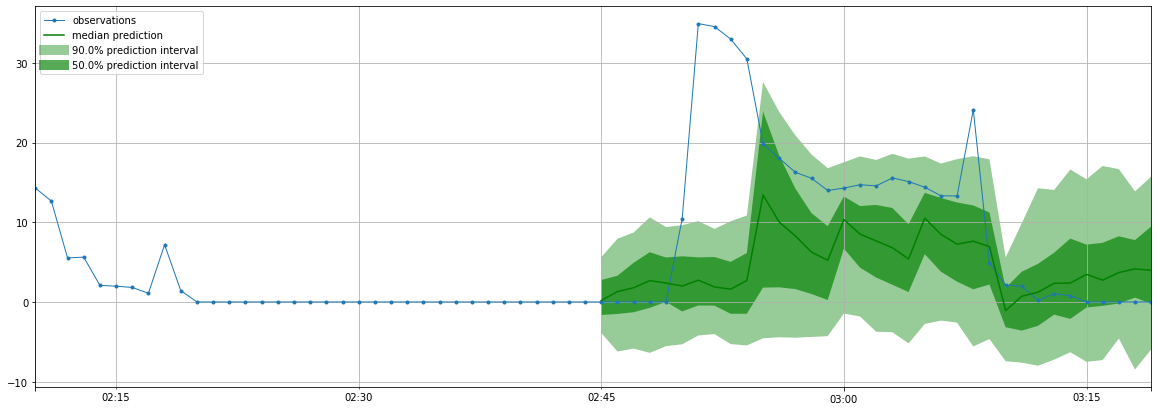

Running evaluation: 100%|██████████| 6/6 [00:00<00:00, 21.04it/s]

{
    "MSE": 179.5346331581737,
    "abs_error": 562.9926958325314,
    "abs_target_sum": 754.6316108703613,
    "abs_target_mean": 12.577193514506023,
    "seasonal_error": 1.3924166628559826,
    "MASE": 7.169428774727721,
    "sMAPE": 1.2101864760857561,
    "MSIS": 156.2221108970657,
    "QuantileLoss[0.1]": 172.72239406442012,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 562.9926958325314,
    "Coverage[0.5]": 0.3666666666666667,
    "QuantileLoss[0.9]": 547.2790539467067,
    "Coverage[0.9]": 0.6333333333333334,
    "RMSE": 13.39905344261951,
    "NRMSE": 1.0653452558526342,
    "ND": 0.7460497118364794,
    "wQuantileLoss[0.1]": 0.22888306237954856,
    "wQuantileLoss[0.5]": 0.7460497118364794,
    "wQuantileLoss[0.9]": 0.7252267809395068,
    "mean_wQuantileLoss": 0.5667198517185116,
    "MAE_Coverage": 0.16666666666666663
}


In [18]:
predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                prediction_length = prediction_length,trunc_length=200)

target = long_predict('arima-timediff')

### test for Indy500

In [22]:
def predict(test_ds,predictor):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    return tss, forecasts

def run_prediction(test_ds, prediction_length):
    with mx.Context(mx.gpu(1)):    
        pred_ret = {}

        # deepAR-Oracle
        model_name = 'deepAR-Oracle-curtrack'
        model=f'deepAR-Oracle-timediff-curtrack-indy-f1min-t{prediction_length}-e1000-r1'
        modeldir = '../models/' + model
        print(f'predicting model={model_name}, plen={prediction_length}')
        predictor =  Predictor.deserialize(Path(modeldir))
        print(f'loading model...done!, ctx:{predictor.ctx}')
        tss, forecasts = predict(test_ds,predictor)
        pred_ret[model_name] = [tss, forecasts]

        # deepAR-Oracle
        model_name = 'deepAR-Oracle'
        model=f'deepAR-Oracle-timediff-all-indy-f1min-t{prediction_length}-e1000-r1'
        modeldir = '../models/' + model
        print(f'predicting model={model_name}, plen={prediction_length}')
        predictor =  Predictor.deserialize(Path(modeldir))
        print(f'loading model...done!, ctx:{predictor.ctx}')
        tss, forecasts = predict(test_ds,predictor)
        pred_ret[model_name] = [tss, forecasts]

        # deepAR
        model_name = 'deepAR'
        model=f'deepAR-timediff-all-indy-f1min-t{prediction_length}-e1000-r1'
        modeldir = '../models/' + model
        print(f'predicting model={model_name}, plen={prediction_length}')
        predictor =  Predictor.deserialize(Path(modeldir))
        print(f'loading model...done!, ctx:{predictor.ctx}')
        tss, forecasts = predict(test_ds,predictor)
        pred_ret[model_name] = [tss, forecasts]

        # naive
        model_name = 'naive'
        print(f'predicting model={model_name}, plen={prediction_length}')
        predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
        tss, forecasts = predict(test_ds,predictor)
        pred_ret[model_name] = [tss, forecasts]

        # arima
        model_name = 'arima'
        print(f'predicting model={model_name}, plen={prediction_length}')
        predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                        prediction_length = prediction_length,trunc_length=60)
        #tss, forecasts = predict(test_ds,predictor)
        pred_ret[model_name] = [tss, forecasts]

        return pred_ret

In [33]:
#calc rank
def eval_rank_bytimediff(test_ds,tss,forecasts,prediction_len):
    """
    timediff models
    
    works for one event only
    
    """

    carlist = []

    # carno-lap# -> elapsed_time[] array
    forecasts_et = dict()

    ds_iter =  iter(test_ds)
    for idx in range(len(test_ds)):
        test_rec = next(ds_iter)
        #global carid
        carno = decode_carids[test_rec['feat_static_cat'][0]]
        #print('car no:', carno)

        if carno not in carlist:
            carlist.append(carno)

        # calc elapsed time
        prediction_len = forecasts[idx].samples.shape[1]
        #forecast_laptime_mean = np.mean(forecasts[idx].samples, axis=0).reshape((prediction_len,1))
        forecast_laptime_mean = np.median(forecasts[idx].samples, axis=0).reshape((prediction_len,1))
        
        timediff_array = tss[idx].values.copy()

        #save the prediction
        completed_laps = len(tss[idx]) - prediction_len + 1
        #print('car no:', carno, 'completed_laps:', completed_laps)
        #key = '%s-%s'%(carno, completed_laps)
        #forecasts_et[key] = elapsed_time[-prediction_len:].copy()
        if completed_laps not in forecasts_et:
            forecasts_et[completed_laps] = {}
        forecasts_et[completed_laps][carno] = [timediff_array[-prediction_len:].copy(),
                                                   forecast_laptime_mean.copy()]


    # calc rank
    rank_ret = []
    for lap in forecasts_et.keys():
        #get car list for this lap
        carlist = list(forecasts_et[lap].keys())
        #print('carlist:', carlist)

        caridmap={key:idx for idx, key in enumerate(carlist)}

        #fill in data
        time_diff = np.zeros((2, len(carlist), prediction_len))
        for carno in carlist:
            carid = caridmap[carno]
            time_diff[0, carid, :] = forecasts_et[lap][carno][0].reshape((prediction_len))
            time_diff[1, carid, :] = forecasts_et[lap][carno][1].reshape((prediction_len))

        #calculate rank    
        idx = np.argsort(time_diff[0], axis=0)
        true_rank = np.argsort(idx, axis=0)

        idx = np.argsort(time_diff[1], axis=0)
        pred_rank = np.argsort(idx, axis=0)

        rank_ret.append([lap, time_diff, true_rank, pred_rank])
        
    return rank_ret
    
   
   
def get_acc(rank_ret,prediction_len):    
    # evaluate
    #top1 accuracy
    top1acc = 0
    top1acc_farmost = 0
    top5acc = 0
    top5acc_farmost = 0
    
    for rec in rank_ret:
        trueRank = rec[2]
        predRank = rec[3]

        #top1 , rank = 0, first col is not prediction
        top1acc += np.sum((trueRank==0) & (predRank==0)) 
        
        top1acc_farmost += np.sum((trueRank[:,-1]==0) & (predRank[:,-1]==0))
        
        #top5
        top5acc += np.sum((trueRank<5) & (predRank<5)) 
        
        top5acc_farmost += np.sum((trueRank[:,-1]<5) & (predRank[:,-1]<5))
        

    print(f'total:{len(rank_ret)}, prediction_length:{prediction_length}') 
    print('top1acc=', top1acc *1.0/ (len(rank_ret)*prediction_length),
          'top1acc_farmost=', top1acc_farmost *1.0/ (len(rank_ret)*prediction_length),
          'top5acc=', top5acc *1.0/ (5*len(rank_ret)*prediction_length),
          'top5acc_farmost=', top5acc_farmost *1.0/ (5*len(rank_ret)*prediction_length),
         )    
    
def get_top1acc_farmost(rank_ret,prediction_len):    
    # evaluate
    #top1 accuracy
    hitcnt = 0
    for rec in rank_ret:
        trueRank = rec[2]
        predRank = rec[3]

        #top1 , rank = 0, first col is not prediction
        hitcnt += np.sum((trueRank[:,-1]==0) & (predRank[:,-1]==0)) 

    print('total:', hitcnt, 'top1acc_farmost=', hitcnt *1.0/ (len(rank_ret)*prediction_length))    



In [24]:
def run_exp(prediction_length, half_moving_win):
    ### create test dataset
    test_cars = []
    train_ds, test_ds,_,_ = make_dataset(-1, prediction_length,freq, 
                                         oracle_mode=MODE_TESTCURTRACK,
                                         run_ts = COL_TIMEDIFF,
                                         test_cars=test_cars,
                                         half_moving_win= half_moving_win)
    pred_ret = run_prediction(test_ds, prediction_length)
    #decode global_carids
    decode_carids={carid:carno for carno, carid in global_carids.items()}
    models = ['deepAR-Oracle','deepAR-Oracle-curtrack','deepAR','naive','arima']
    for model in models:
        print('model:', model)
        tss, forecasts = pred_ret[model]

        rank_ret = eval_rank_bytimediff(test_ds,tss,forecasts,prediction_length)
        get_acc(rank_ret,prediction_length)
        
    return pred_ret

#### test 10

In [27]:
prediction_length = 10
### create test dataset
test_cars = list(completed_car_numbers)
train_ds, test_ds,_,_ = make_dataset(events_id[event], prediction_length,freq, 
                                     oracle_mode=MODE_TESTCURTRACK,
                                     run_ts = COL_TIMEDIFF,
                                     test_cars=test_cars)
pred_ret10 = run_prediction(prediction_length)

INFO:root:Using GPU
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]
INFO:root:Using GPU


tss len=108, forecasts len=108


INFO:root:Using GPU


tss len=108, forecasts len=108
tss len=108, forecasts len=108
tss len=108, forecasts len=108
tss len=108, forecasts len=108


In [34]:
#decode global_carids
decode_carids={carid:carno for carno, carid in global_carids.items()}
models = ['deepAR-Oracle','deepAR-Oracle-curtrack','deepAR','naive','arima']
for model in models:
    print('model:', model)
    tss, forecasts = pred_ret10[model]
    
    rank_ret = eval_rank_bytimediff()
    get_acc()


model: deepAR-Oracle
total: 6 top1acc= 0.25 top1acc_farmost= 0.0 top5acc= 0.53 top5acc_farmost= 0.02666666666666667
model: deepAR-Oracle-curtrack
total: 6 top1acc= 0.21666666666666667 top1acc_farmost= 0.016666666666666666 top5acc= 0.55 top5acc_farmost= 0.03666666666666667
model: deepAR
total: 6 top1acc= 0.31666666666666665 top1acc_farmost= 0.0 top5acc= 0.55 top5acc_farmost= 0.03666666666666667
model: naive
total: 6 top1acc= 0.23333333333333334 top1acc_farmost= 0.016666666666666666 top5acc= 0.54 top5acc_farmost= 0.03666666666666667
model: arima
total: 6 top1acc= 0.26666666666666666 top1acc_farmost= 0.0 top5acc= 0.5233333333333333 top5acc_farmost= 0.03


#### test t5

In [67]:
prediction_length = 5
### create test dataset
test_cars = list(completed_car_numbers)
train_ds, test_ds,_,_ = make_dataset(events_id[event], prediction_length,freq, 
                                     oracle_mode=MODE_TESTCURTRACK,
                                     run_ts = COL_TIMEDIFF,
                                     test_cars=test_cars)


====event:Indy500, train_len=160, max_len=200, min_len=200
carno:1, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=3，len=146
carno:4, totallen:200, nancount:0, test_reccnt:18
carno:6, totallen:200, nancount:0, test_reccnt:18
carno:9, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=10，len=57
carno:12, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=13，len=67
carno:15, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=18，len=137
carno:20, totallen:200, nancount:0, test_reccnt:18
carno:22, totallen:200, nancount:0, test_reccnt:18
carno:23, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=24，len=154
carno:25, totallen:200, nancount:0, test_reccnt:18
carno:27, totallen:200, nancount:0, test_reccnt:18
carno:28, totallen:200, nancount:0, test_reccnt:18
carno:29, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=30，len=46
a short ts: carid=32，len=110
a short ts: carid=33，len=46
carno:60, totallen:200, nancount:0, test_reccnt:18
carn

In [68]:
pred_ret5 = run_prediction(prediction_length)

INFO:root:Using GPU


predicting model=deepAR-Oracle-curtrack, plen=5


INFO:root:Using GPU


tss len=324, forecasts len=324
predicting model=deepAR-Oracle, plen=5


INFO:root:Using GPU


tss len=324, forecasts len=324
predicting model=deepAR, plen=5
tss len=324, forecasts len=324
predicting model=naive, plen=5
tss len=324, forecasts len=324
predicting model=arima, plen=5
tss len=324, forecasts len=324


In [69]:
#decode global_carids
decode_carids={carid:carno for carno, carid in global_carids.items()}
models = ['deepAR-Oracle','deepAR-Oracle-curtrack','deepAR','naive','arima']
for model in models:
    print('model:', model)
    tss, forecasts = pred_ret5[model]
    
    rank_ret = eval_rank_bytimediff()
    get_acc()

model: deepAR-Oracle
total: 18 top1acc= 0.5888888888888889 top1acc_farmost= 0.03333333333333333 top5acc= 1.2977777777777777 top5acc_farmost= 0.08888888888888889
model: deepAR-Oracle-curtrack
total: 18 top1acc= 0.6111111111111112 top1acc_farmost= 0.011111111111111112 top5acc= 1.2977777777777777 top5acc_farmost= 0.08888888888888889
model: deepAR
total: 18 top1acc= 0.6111111111111112 top1acc_farmost= 0.011111111111111112 top5acc= 1.2866666666666666 top5acc_farmost= 0.08444444444444445
model: naive
total: 18 top1acc= 0.5555555555555556 top1acc_farmost= 0.011111111111111112 top5acc= 1.2955555555555556 top5acc_farmost= 0.09555555555555556
model: arima
total: 18 top1acc= 0.6 top1acc_farmost= 0.022222222222222223 top5acc= 1.288888888888889 top5acc_farmost= 0.08444444444444445


#### test 2

In [10]:
prediction_length = 2
freq='1min'
test_cars = []
### create test dataset
train_ds, test_ds,_,_ = make_dataset(-1, prediction_length,freq, 
                                     oracle_mode=MODE_TESTCURTRACK,
                                     run_ts = COL_TIMEDIFF,
                                     test_cars=test_cars)

====event:Phoenix, train_len=200, max_len=250, min_len=250
carno:1, totallen:250, nancount:0, test_reccnt:48
carno:4, totallen:241, nancount:9, test_reccnt:39
carno:5, totallen:250, nancount:0, test_reccnt:48
carno:6, totallen:250, nancount:0, test_reccnt:48
carno:9, totallen:250, nancount:0, test_reccnt:48
carno:10, totallen:229, nancount:21, test_reccnt:27
a short ts: carid=12，len=154
carno:14, totallen:250, nancount:0, test_reccnt:48
carno:15, totallen:250, nancount:0, test_reccnt:48
carno:18, totallen:249, nancount:1, test_reccnt:47
a short ts: carid=19，len=40
carno:20, totallen:250, nancount:0, test_reccnt:48
carno:21, totallen:249, nancount:1, test_reccnt:47
carno:22, totallen:250, nancount:0, test_reccnt:48
carno:23, totallen:248, nancount:2, test_reccnt:46
carno:26, totallen:249, nancount:1, test_reccnt:47
carno:27, totallen:250, nancount:0, test_reccnt:48
carno:28, totallen:250, nancount:0, test_reccnt:48
carno:30, totallen:250, nancount:0, test_reccnt:48
a short ts: carid=32，

In [11]:
pred_ret2 = run_prediction(prediction_length)

INFO:root:Using GPU


predicting model=deepAR-Oracle-curtrack, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR-Oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR, plen=2
loading model...done!, ctx:gpu(0)
tss len=5045, forecasts len=5045
predicting model=naive, plen=2


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=5045, forecasts len=5045
predicting model=arima, plen=2


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)


In [12]:
#decode global_carids
decode_carids={carid:carno for carno, carid in global_carids.items()}
models = ['deepAR-Oracle','deepAR-Oracle-curtrack','deepAR','naive','arima']
for model in models:
    print('model:', model)
    tss, forecasts = pred_ret2[model]
    
    rank_ret = eval_rank_bytimediff()
    get_acc()

model: deepAR-Oracle
total:138, prediction_length:2
top1acc= 0.7427536231884058 top1acc_farmost= 0.36231884057971014 top5acc= 0.9326086956521739 top5acc_farmost= 0.4572463768115942
model: deepAR-Oracle-curtrack
total:138, prediction_length:2
top1acc= 0.7644927536231884 top1acc_farmost= 0.37318840579710144 top5acc= 0.9384057971014492 top5acc_farmost= 0.4601449275362319
model: deepAR
total:138, prediction_length:2
top1acc= 0.75 top1acc_farmost= 0.3695652173913043 top5acc= 0.9376811594202898 top5acc_farmost= 0.4601449275362319
model: naive
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: arima
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261


In [15]:
# test half moving win
pred_ret2_nohalfwin = run_exp(2, False)

====event:Phoenix, train_len=200, max_len=250, min_len=250
carno:1, totallen:250, nancount:0, test_reccnt:24
carno:4, totallen:241, nancount:9, test_reccnt:20
carno:5, totallen:250, nancount:0, test_reccnt:24
carno:6, totallen:250, nancount:0, test_reccnt:24
carno:9, totallen:250, nancount:0, test_reccnt:24
carno:10, totallen:229, nancount:21, test_reccnt:14
a short ts: carid=12，len=154
carno:14, totallen:250, nancount:0, test_reccnt:24
carno:15, totallen:250, nancount:0, test_reccnt:24
carno:18, totallen:249, nancount:1, test_reccnt:24
a short ts: carid=19，len=40
carno:20, totallen:250, nancount:0, test_reccnt:24
carno:21, totallen:249, nancount:1, test_reccnt:24
carno:22, totallen:250, nancount:0, test_reccnt:24
carno:23, totallen:248, nancount:2, test_reccnt:23
carno:26, totallen:249, nancount:1, test_reccnt:24
carno:27, totallen:250, nancount:0, test_reccnt:24
carno:28, totallen:250, nancount:0, test_reccnt:24
carno:30, totallen:250, nancount:0, test_reccnt:24
a short ts: carid=32，

INFO:root:Using GPU


predicting model=deepAR-Oracle-curtrack, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR-Oracle, plen=2
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR, plen=2
loading model...done!, ctx:gpu(0)
tss len=5045, forecasts len=5045
predicting model=naive, plen=2


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=5045, forecasts len=5045
predicting model=arima, plen=2
model: deepAR-Oracle
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: deepAR-Oracle-curtrack
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: deepAR
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: naive
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: arima
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261


In [25]:
# test half moving win
prediction_length = 0
pred_ret5_halfwin = run_exp(5, True)

====event:Phoenix, train_len=200, max_len=250, min_len=250
carno:1, totallen:250, nancount:0, test_reccnt:23
carno:4, totallen:241, nancount:9, test_reccnt:18
carno:5, totallen:250, nancount:0, test_reccnt:23
carno:6, totallen:250, nancount:0, test_reccnt:23
carno:9, totallen:250, nancount:0, test_reccnt:23
carno:10, totallen:229, nancount:21, test_reccnt:12
a short ts: carid=12，len=154
carno:14, totallen:250, nancount:0, test_reccnt:23
carno:15, totallen:250, nancount:0, test_reccnt:23
carno:18, totallen:249, nancount:1, test_reccnt:22
a short ts: carid=19，len=40
carno:20, totallen:250, nancount:0, test_reccnt:23
carno:21, totallen:249, nancount:1, test_reccnt:22
carno:22, totallen:250, nancount:0, test_reccnt:23
carno:23, totallen:248, nancount:2, test_reccnt:22
carno:26, totallen:249, nancount:1, test_reccnt:22
carno:27, totallen:250, nancount:0, test_reccnt:23
carno:28, totallen:250, nancount:0, test_reccnt:23
carno:30, totallen:250, nancount:0, test_reccnt:23
a short ts: carid=32，

INFO:root:Using GPU


predicting model=deepAR-Oracle-curtrack, plen=5
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=2387, forecasts len=2387
predicting model=deepAR-Oracle, plen=5
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=2387, forecasts len=2387
predicting model=deepAR, plen=5
loading model...done!, ctx:gpu(0)
tss len=2387, forecasts len=2387
predicting model=naive, plen=5
tss len=2387, forecasts len=2387
predicting model=arima, plen=5
model: deepAR-Oracle
total:132, prediction_length:0
top1acc= inf top1acc_farmost= inf top5acc= inf top5acc_farmost= inf
model: deepAR-Oracle-curtrack


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in double_scalars
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in double_scalars
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in double_scalars
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in double_scalars


total:132, prediction_length:0
top1acc= inf top1acc_farmost= inf top5acc= inf top5acc_farmost= inf
model: deepAR
total:132, prediction_length:0
top1acc= inf top1acc_farmost= inf top5acc= inf top5acc_farmost= inf
model: naive
total:132, prediction_length:0
top1acc= inf top1acc_farmost= inf top5acc= inf top5acc_farmost= inf
model: arima
total:132, prediction_length:0
top1acc= inf top1acc_farmost= inf top5acc= inf top5acc_farmost= inf


In [17]:
# test half moving win
pred_ret5_nohalfwin = run_exp(5, False)

INFO:root:Using GPU


====event:Phoenix, train_len=200, max_len=250, min_len=250
carno:1, totallen:250, nancount:0, test_reccnt:9
carno:4, totallen:241, nancount:9, test_reccnt:8
carno:5, totallen:250, nancount:0, test_reccnt:9
carno:6, totallen:250, nancount:0, test_reccnt:9
carno:9, totallen:250, nancount:0, test_reccnt:9
carno:10, totallen:229, nancount:21, test_reccnt:5
a short ts: carid=12，len=154
carno:14, totallen:250, nancount:0, test_reccnt:9
carno:15, totallen:250, nancount:0, test_reccnt:9
carno:18, totallen:249, nancount:1, test_reccnt:9
a short ts: carid=19，len=40
carno:20, totallen:250, nancount:0, test_reccnt:9
carno:21, totallen:249, nancount:1, test_reccnt:9
carno:22, totallen:250, nancount:0, test_reccnt:9
carno:23, totallen:248, nancount:2, test_reccnt:9
carno:26, totallen:249, nancount:1, test_reccnt:9
carno:27, totallen:250, nancount:0, test_reccnt:9
carno:28, totallen:250, nancount:0, test_reccnt:9
carno:30, totallen:250, nancount:0, test_reccnt:9
a short ts: carid=32，len=174
carno:59,

INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR-Oracle, plen=5
loading model...done!, ctx:gpu(0)


INFO:root:Using GPU


tss len=5045, forecasts len=5045
predicting model=deepAR, plen=5
loading model...done!, ctx:gpu(0)
tss len=5045, forecasts len=5045
predicting model=naive, plen=5
tss len=5045, forecasts len=5045
predicting model=arima, plen=5
model: deepAR-Oracle
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: deepAR-Oracle-curtrack
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: deepAR
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: naive
total:138, prediction_length:2
top1acc= 0.8876811594202898 top1acc_farmost= 0.427536231884058 top5acc= 0.9485507246376812 top5acc_farmost= 0.4673913043478261
model: arima
total:138, prediction_length:2
top1acc= 0.88768115

### test

In [96]:
pred_ret = pred_ret2_halfwin
model = 'deepAR-Oracle'
tss, forecasts = pred_ret[model]
rank_ret = eval_rank_bytimediff()

In [26]:
tss, forecasts = pred_ret5_halfwin['deepAR-Oracle']
rank_ret = eval_rank_bytimediff(test_ds,tss,forecasts,5)
get_acc(rank_ret,5)

IndexError: list index out of range

In [29]:
%debug

> <ipython-input-23-87bad99779e9>(26)eval_rank_bytimediff()
     24 
     25         # calc elapsed time
---> 26         prediction_len = forecasts[idx].samples.shape[1]
     27         #forecast_laptime_mean = np.mean(forecasts[idx].samples, axis=0).reshape((prediction_len,1))
     28         forecast_laptime_mean = np.median(forecasts[idx].samples, axis=0).reshape((prediction_len,1))

ipdb> p idx
2387
ipdb> quit


In [32]:
len(test_ds)

5045

In [97]:
rank_ret[1][2][:,0:4]

array([[11, 10, 10, 10],
       [16, 15, 15, 15],
       [17, 17, 17, 16],
       [ 4,  4,  4,  4],
       [ 3,  3,  3,  3],
       [12, 12, 12, 12],
       [ 5,  5,  5,  5],
       [ 8,  8,  8,  8],
       [ 9,  9,  9,  9],
       [ 1,  1,  1,  0],
       [ 6,  6,  6,  6],
       [ 7,  7,  7,  7],
       [10, 11, 11, 11],
       [ 2,  2,  2,  2],
       [ 0,  0,  0,  1],
       [14, 14, 14, 14],
       [15, 16, 16, 17],
       [13, 13, 13, 13]])

In [98]:
rank_ret[1][3][:,:]

array([[10, 10, 10, 10, 11, 10, 10, 11, 11, 11],
       [16, 16, 15, 15, 15, 16, 16, 16, 16, 16],
       [15, 13, 11, 11,  9,  8,  7,  7,  5,  5],
       [ 2,  3,  3,  4,  3,  4,  4,  4,  4,  4],
       [ 3,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [14, 15, 16, 16, 16, 15, 15, 15, 15, 15],
       [ 7,  7,  6,  7,  7,  7,  8,  8,  8,  8],
       [ 8,  6,  7,  6,  6,  6,  6,  5,  7,  7],
       [ 9,  9,  9,  9, 10, 11, 12, 13, 12, 13],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  0,  1],
       [ 6,  8,  8,  8,  8,  9,  9,  9, 10, 10],
       [ 5,  5,  5,  5,  4,  3,  3,  3,  3,  3],
       [11, 11, 12, 12, 12, 12, 11, 10,  9,  9],
       [ 4,  4,  4,  3,  5,  5,  5,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [13, 14, 14, 14, 14, 14, 13, 12, 13, 12],
       [12, 12, 13, 13, 13, 13, 14, 14, 14, 14]])

In [99]:
tss, forecasts = pred_ret['deepAR-Oracle-curtrack']
forecasts[0].samples.shape[1]

10

In [80]:
prediction_length

2

In [61]:
pred_ret.keys()

dict_keys(['deepAR-Oracle-curtrack', 'deepAR-Oracle', 'deepAR', 'naive', 'arima'])

In [87]:
tss, forecasts = 0, 0
model = 'deepAR-Oracle-curtrack'

tss, forecasts = pred_ret2[model]

rank_ret = eval_rank_bytimediff()
get_acc()

total:38, prediction_length:2
top1acc= 1.4342105263157894 top1acc_farmost= 0.06578947368421052 top5acc= 3.1447368421052633 top5acc_farmost= 0.23157894736842105


In [81]:
rank_ret[0]

[191, array([[[ 1.07908001e+01,  9.40999985e+00,  2.19849992e+00,
           4.95380020e+00,  6.79769993e+00,  5.86180019e+00,
           6.27470016e+00,  7.25129986e+00,  8.30270004e+00,
           8.69169998e+00],
         [ 1.34540005e+01,  1.37714996e+01,  6.71460009e+00,
           7.73729992e+00,  8.90089989e+00,  9.32170010e+00,
           1.10153999e+01,  1.24775000e+01,  1.41831999e+01,
           1.47798004e+01],
         [ 2.25741997e+01,  1.51399002e+01,  7.21670008e+00,
           7.74730015e+00,  7.61590004e+00,  7.68660021e+00,
           8.75629997e+00,  8.77779961e+00,  9.19769955e+00,
           9.31120014e+00],
         [ 3.13089991e+00,  3.04380012e+00,  2.89099991e-01,
           2.31369996e+00,  2.88319993e+00,  2.03360009e+00,
           2.75620008e+00,  3.35999990e+00,  4.38660002e+00,
           4.59280014e+00],
         [ 2.13310003e+00,  1.97790003e+00,  1.97899997e-01,
           1.04449999e+00,  7.76700020e-01,  0.00000000e+00,
           0.00000000e+00,  0

In [88]:
forecasts[0].samples.shape

(100, 10)

In [86]:
next(iter(test_ds))

{'target': array([ 0.8457,  1.1695,  1.4571,  1.7348,  1.9046,  2.2024,  2.5373,
         2.9428,  3.1394,  3.4255,  3.3099,  3.3574,  3.3771,  3.4335,
         3.5343,  3.7273,  4.0755,  4.4987,  4.7892,  5.254 ,  5.4827,
         5.6939,  5.937 ,  6.2284,  5.6873,  4.545 ,  3.9387,  3.0526,
         2.6946,  0.6026,  0.    ,  9.8879, 33.9997, 20.399 ,  2.9675,
         3.3547,  3.6985,  4.0173,  4.3862,  4.3794,  4.0448,  3.7866,
         3.9373,  3.8756,  3.7387,  3.5924,  3.4381,  4.3645,  2.9646,
         1.1763,  3.3169,  2.5181,  2.6911,  3.7606,  1.1717,  2.3381,
         2.5709,  2.889 ,  1.5054,  1.2679,  2.1801,  2.2516,  0.2976,
         0.8706,  1.044 ,  1.1731,  1.5736,  2.4794,  1.6835,  5.1985,
        16.6342, 17.5929,  3.189 ,  6.6302,  8.855 , 10.24  , 11.9785,
        13.3738, 14.5056, 15.3947, 16.1128, 16.9743, 17.7534, 18.4969,
        19.4187, 20.3536, 22.0253, 22.4716, 22.8629, 22.6139, 24.0865,
        24.0472, 25.5406, 15.3921,  4.9092,  4.2708,  1.9713,  2.06